In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, r2_score
import os, math

warnings.filterwarnings('ignore')

In [2]:
data = 'car_sales_data.csv'
df = pd.read_csv(data)
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [3]:
print("Loaded Dataset:" , data)
print("Shape:", df.shape)

Loaded Dataset: car_sales_data.csv
Shape: (50000, 7)


In [4]:
display(df.head())
display(df.sample(5))
print("\nColumn dtypes:")
display(df.dtypes)

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
18898,Ford,Mondeo,2.0,Petrol,1998,171082,3348
34411,Ford,Mondeo,1.6,Diesel,2011,85580,14574
44815,Ford,Focus,1.8,Petrol,2005,73826,10800
40937,Ford,Fiesta,1.2,Diesel,2021,9440,27336
11324,BMW,Z4,2.4,Petrol,1996,196633,2868



Column dtypes:


Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Price                    int64
dtype: object

In [5]:
print("\nMissing values per column:")
display(df.isna().sum())


Missing values per column:


Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64

In [6]:
candidates = [c for c in df.columns if c.lower() in ('sold','is_sold','sale','is_sold?','sold?','target','status')]
if len(candidates) > 0:
    target_col = candidates[0]
    uniques = df[target_col].dropna().unique()
    if df[target_col].nunique() <= 10 and df[target_col].dtype != float:
        problem_type = 'classification'
    else:
        problem_type = 'regression'
else:
    for cand in ('price','Price','sale_price','SalePrice','price_usd'):
        if cand in df.columns:
            target_col = cand
            problem_type = 'regression'
            break
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    non_id_numeric = [c for c in numeric_cols if df[c].nunique()>10]
    if len(non_id_numeric) > 0:
        target_col = non_id_numeric[0]
        problem_type = 'regression'
    else:
        cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
        if len(cat_cols) > 0:
            target_col = cat_cols[0]
            problem_type = 'classification'
        else:
            target_col = df.columns[-1]
            problem_type = 'classification'
print(f"\nChosen target column: {target_col}  (problem_type = {problem_type})")


Chosen target column: Price  (problem_type = regression)


In [7]:
df = df.copy()
df = df.dropna(subset=[target_col])

In [8]:
def preprocess_dataframe(df,target_col):
    dfp = df.copy()
    for col in dfp.columns:
        if dfp[col].dtype == 'object':
            sample = dfp[col].dropna().astype(str).head(50).tolist()
            if any('/' in s or '-' in s for s in sample):
                try:
                    dfp[col+'_dt'] = pd.to_datetime(dfp[col], errors='coerce')
                except:
                    pass
    for col in dfp.select_dtypes(include=['object']).columns:
        if dfp[col].str.contains(r'\d', na=False).sum() > len(dfp)*0.1:
            nums = dfp[col].str.extract('([0-9]+\\.?[0-9]*)', expand=False)
            if nums.notna().sum() > 0:
                dfp[col+'_num'] = pd.to_numeric(nums, errors='coerce')
    for col in dfp.select_dtypes(include=[np.number]).columns:
        dfp[col] = dfp[col].fillna(dfp[col].median())
    cat_cols = dfp.select_dtypes(include=['object']).columns.tolist()
    le_dict = {}
    for col in cat_cols:
        if dfp[col].nunique() <= 50:
            le = LabelEncoder()
            dfp[col] = dfp[col].fillna('Unknown')
            dfp[col] = le.fit_transform(dfp[col].astype(str))
            le_dict[col] = le
        else:
            # drop very high cardinality text columns (but keep lengths)
            dfp[col + '_len'] = dfp[col].fillna('').astype(str).apply(len)
            dfp.drop(columns=[col], inplace=True)
    return dfp, le_dict
dfp, le_encoders = preprocess_dataframe(df, target_col)
print("\nAfter preprocessing, shape:", dfp.shape)
display(dfp.head())


After preprocessing, shape: (50000, 8)


,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price,Model_num
0,1,3,1.0,2,2002,127300,3074,4.0
1,2,0,4.0,2,2016,57850,49704,718.0
2,1,7,1.6,0,2014,39190,24072,4.0
3,3,11,1.8,1,1988,210814,1705,4.0
4,4,9,1.0,2,2006,127869,4101,4.0


In [9]:
if problem_type == 'classification':
    y = dfp[target_col].astype(str)
    le_target = LabelEncoder()
    y_enc = le_target.fit_transform(y)
    y = y_enc
else:
    y = pd.to_numeric(dfp[target_col], errors='coerce').fillna(dfp[target_col].median())
X = dfp.drop(columns=[target_col])

X = X.select_dtypes(exclude=['datetime64[ns]']).copy()
X = X.select_dtypes(include=[np.number]).copy()

print("\nFinal feature matrix shape:", X.shape)
print("Number of features:", X.shape[1])
display(X.columns.tolist()[:50])


Final feature matrix shape: (50000, 7)
Number of features: 7


['Manufacturer',
 'Model',
 'Engine size',
 'Fuel type',
 'Year of manufacture',
 'Mileage',
 'Model_num']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=(y if problem_type=='classification' else None))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

if problem_type == 'classification':
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42)
    }
else:
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression(),
        'SVR': SVR(),
        'KNN Regressor': KNeighborsRegressor(),
        'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
        'AdaBoost Regressor': AdaBoostRegressor(n_estimators=50, random_state=42)
    }

results = {}
os.makedirs('car_sales_visualizations', exist_ok=True)

In [11]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {'model': model, 'predictions': preds}
    if problem_type == 'classification':
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, average='weighted', zero_division=0)
        rec = recall_score(y_test, preds, average='weighted', zero_division=0)
        f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
        results[name].update({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
        print(f"{name}: accuracy={acc:.4f}, f1={f1:.4f}")
    else:
        mse = mean_squared_error(y_test, preds)
        rmse = math.sqrt(mse)
        r2 = r2_score(y_test, preds)
        results[name].update({'mse': mse, 'rmse': rmse, 'r2': r2})
        print(f"{name}: RMSE={rmse:.4f}, R2={r2:.4f}")

if problem_type == 'classification':
    best_model_name = max(results.keys(), key=lambda n: results[n]['accuracy'])
else:
    best_model_name = max(results.keys(), key=lambda n: results[n]['r2'])

with open(f"best_model_{best_model_name.replace(' ', '_')}.pkl", "wb") as f:
    pickle.dump(results[best_model_name]['model'], f)
with open("scaler_car_sales.pkl", "wb") as f:
    pickle.dump(scaler, f)

print(f"\nSaved best model: {best_model_name}")
print("Visualizations saved to: car_sales_visualizations")

Random Forest: RMSE=667.2867, R2=0.9984
Gradient Boosting: RMSE=1786.3798, R2=0.9882
Linear Regression: RMSE=9296.8736, R2=0.6815
SVR: RMSE=15809.7074, R2=0.0790
KNN Regressor: RMSE=799.8155, R2=0.9976
Decision Tree Regressor: RMSE=1067.9943, R2=0.9958
AdaBoost Regressor: RMSE=7776.3794, R2=0.7772

Saved best model: Random Forest
Visualizations saved to: car_sales_visualizations


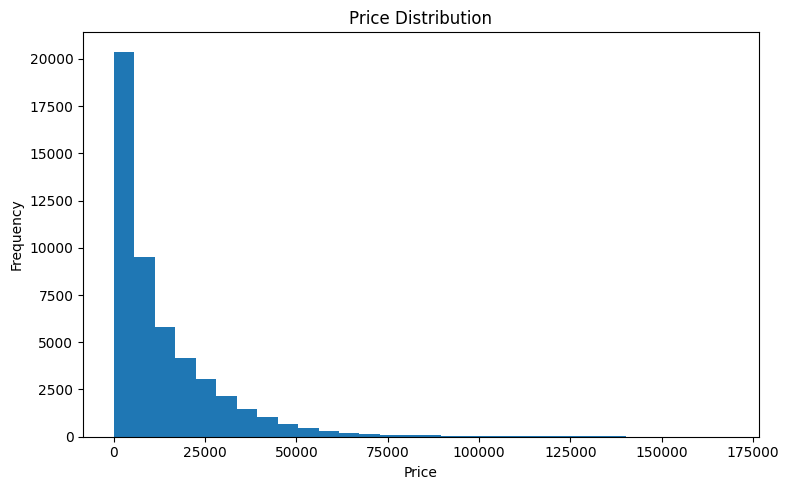

In [12]:
plt.figure(figsize=(8,5))
if problem_type == 'classification':
    vals, counts = np.unique(y_test, return_counts=True)
    plt.bar(vals, counts)
    plt.xlabel('Class (encoded)'); plt.ylabel('Count'); plt.title(f'Target Distribution (test) - {target_col}')
else:
    plt.hist(y, bins=30)
    plt.xlabel(target_col); plt.ylabel('Frequency'); plt.title(f'{target_col} Distribution')
plt.tight_layout()
plt.savefig('car_sales_visualizations/01_target_dist.png')
plt.show()
plt.close()

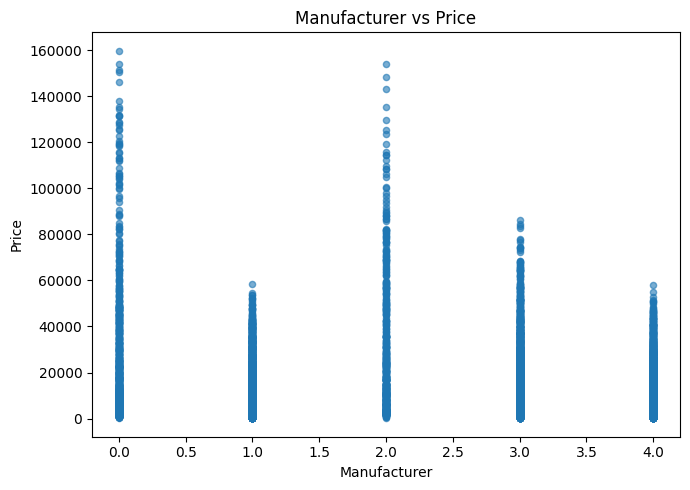

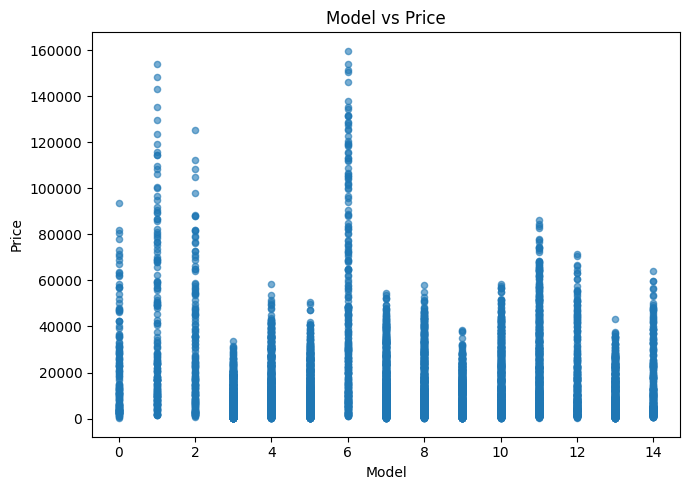

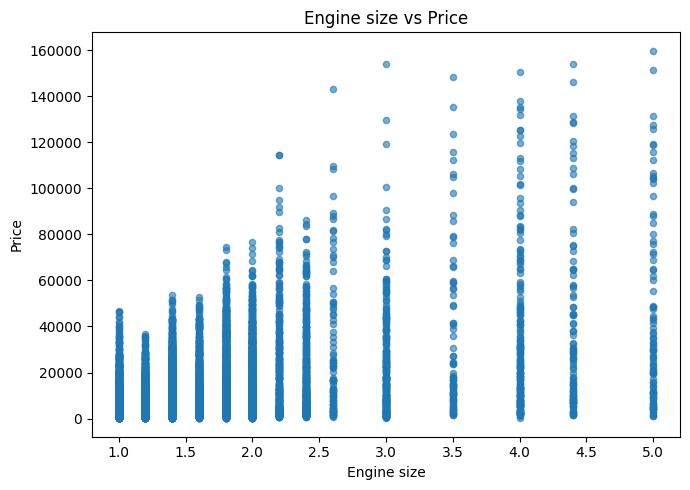

In [13]:
num_feats = X.columns.tolist()
top3 = num_feats[:3] if len(num_feats) >= 3 else num_feats
for i, feat in enumerate(top3):
    plt.figure(figsize=(7,5))
    plt.scatter(X_test[feat], y_test, s=20, alpha=0.6)
    plt.xlabel(feat); plt.ylabel(target_col); plt.title(f'{feat} vs {target_col}')
    plt.tight_layout()
    plt.savefig(f'car_sales_visualizations/02_scatter_{i+1}_{feat}.png')
    plt.show()
    plt.close()

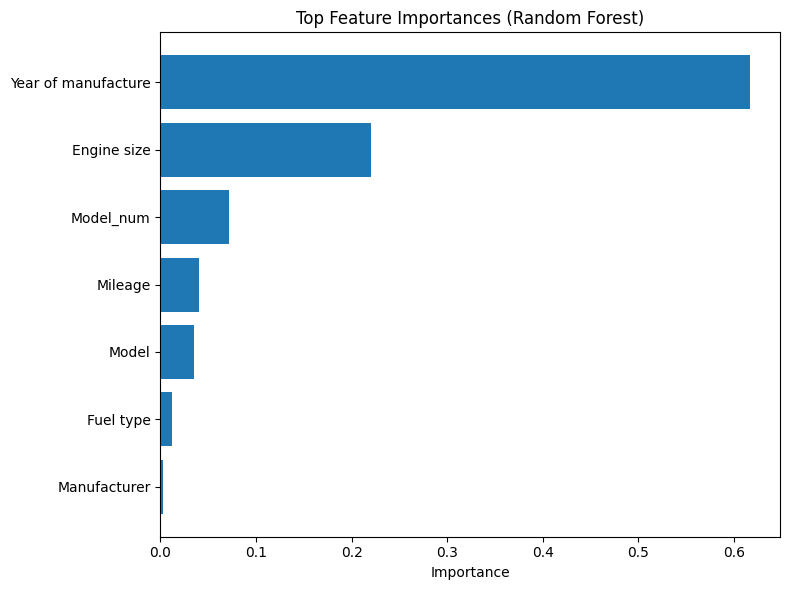

In [14]:
if 'Random Forest' in results:
    rf = results['Random Forest']['model']
    if hasattr(rf, 'feature_importances_'):
        importances = rf.feature_importances_
        feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(8,6))
        plt.barh(feat_imp['feature'].head(15), feat_imp['importance'].head(15))
        plt.gca().invert_yaxis()
        plt.xlabel('Importance'); plt.title('Top Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.savefig('car_sales_visualizations/03_feature_importance.png')
        plt.show()
        plt.close()
        feat_imp.to_csv('car_sales_visualizations/feature_importances.csv', index=False)

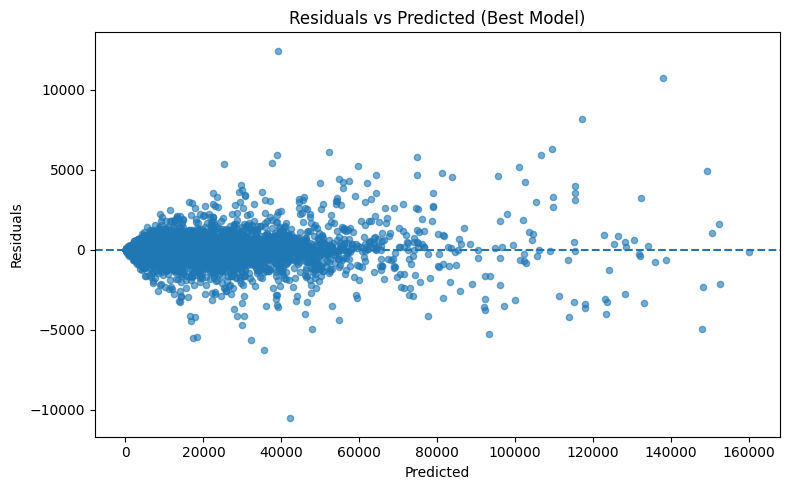

In [15]:
if problem_type == 'regression':
    best = results[best_model_name]['model']
    preds = results[best_model_name]['predictions']
    residuals = y_test - preds
    plt.figure(figsize=(8,5))
    plt.scatter(preds, residuals, s=20, alpha=0.6)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('Residuals vs Predicted (Best Model)')
    plt.tight_layout()
    plt.savefig('car_sales_visualizations/04_residuals.png')
    plt.show()
    plt.close()

In [17]:
if problem_type == 'classification':
    from sklearn.metrics import confusion_matrix
    n = len(results)
    cols = 3
    rows = math.ceil(n/cols)
    plt.figure(figsize=(5*cols,4*rows))
    idx = 1
    for name, res in results.items():
        cm = confusion_matrix(y_test, res['predictions'])
        plt.subplot(rows, cols, idx)
        plt.imshow(cm, interpolation='nearest')
        plt.title(name)
        plt.colorbar()
        plt.xlabel('Predicted'); plt.ylabel('True')
        idx += 1
    plt.tight_layout()
    plt.savefig('car_sales_visualizations/05_confusion_matrices.png')
    plt.show()
    plt.close()

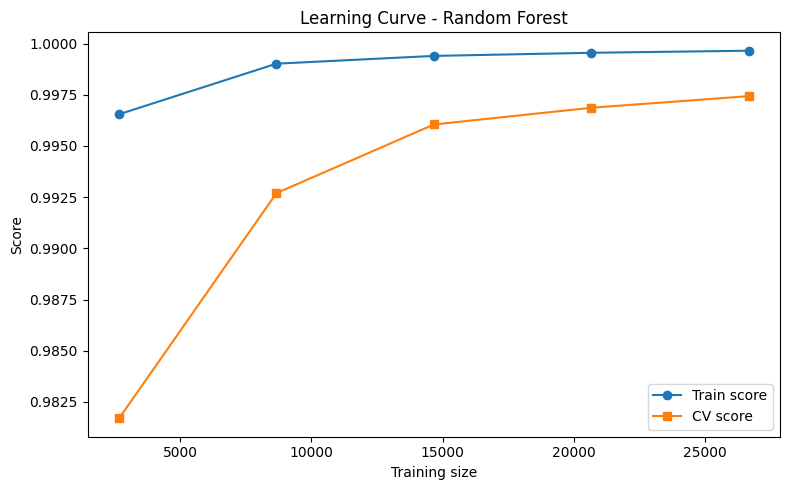

In [18]:
plt.figure(figsize=(8,5))
train_sizes, train_scores, val_scores = learning_curve(results[best_model_name]['model'], X_train_scaled, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), marker='o', label='Train score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), marker='s', label='CV score')
plt.xlabel('Training size'); plt.ylabel('Score'); plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.tight_layout()
plt.savefig('car_sales_visualizations/06_learning_curve.png')
plt.show()
plt.close()

In [19]:
summary_rows = []
if problem_type == 'classification':
    for name, res in results.items():
        summary_rows.append({'Model': name, 'Accuracy': res['accuracy'], 'Precision': res['precision'], 'Recall': res['recall'], 'F1': res['f1']})
else:
    for name, res in results.items():
        summary_rows.append({'Model': name, 'RMSE': res['rmse'], 'R2': res['r2']})
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv('car_sales_visualizations/model_performance.csv', index=False)

In [20]:
print("\nCompleted training and visualization. Files created:")
for f in os.listdir('car_sales_visualizations')[:50]:
    print(" -", f)


Completed training and visualization. Files created:
 - feature_importances.csv
 - 06_learning_curve.png
 - 02_scatter_2_Model.png
 - 02_scatter_1_Manufacturer.png
 - model_performance.csv
 - 03_feature_importance.png
 - 04_residuals.png
 - 01_target_dist.png
 - 02_scatter_3_Engine size.png
